In [370]:
import numpy as np 
np.set_printoptions(precision=4)
from scipy.stats import multivariate_normal as mvn
from tqdm import tqdm
from scipy.special import j1
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['axes.linewidth'] = 3
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['axes.titlepad'] = 8.0
mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['xtick.major.width'] = 3
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['ytick.major.width'] = 3
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['lines.markersize'] = 5
mpl.rcParams['lines.linewidth'] = 5
mpl.rcParams['legend.fontsize'] = 15

In [371]:
# Define the target distribution
mean1 = np.array([0.35, 0.38])
cov1 = np.array([
    [0.01, 0.004],
    [0.004, 0.01]
])
w1 = 0.6

mean2 = np.array([0.68, 0.25])
cov2 = np.array([
    [0.005, -0.003],
    [-0.003, 0.005]
])
w2 = 0.2

mean3 = np.array([0.56, 0.64])
cov3 = np.array([
    [0.008, 0.0],
    [0.0, 0.004]
])

w3 = 0.1

mean4 = np.array([0.22, 0.74])
cov4 = np.array([
    [0.01, 0.004],
    [0.004, 0.01]
])
w4 = 0.1

def pdf(x):
    return w1 * mvn.pdf(x, mean1, cov1) + \
           w2 * mvn.pdf(x, mean2, cov2) + \
           w3 * mvn.pdf(x, mean3, cov3) + \
           w4 * mvn.pdf(x, mean4, cov4)
        
# Define a 1-by-1 2D search space
L_list = np.array([1.0, 1.0])  # boundaries for each dimension

# Discretize the search space into 100-by-100 mesh grids
num_grid = 100
grids_x, grids_y = np.meshgrid(
    np.linspace(0, L_list[0], num_grid),
    np.linspace(0, L_list[1], num_grid)
)
grids = np.array([grids_x.ravel(), grids_y.ravel()]).T
dx = 1.0 / (num_grid - 1)
dy = 1.0 / (num_grid - 1)

In [372]:
def theta(x, y):
    return np.arctan2(y, x)

def dtheta_dx(x, y):
    return -y / (x**2 + y**2)

def dtheta_dy(x, y):
    return x / (x**2 + y**2)

def injection(x,y):
    return theta(x, y), dtheta_dx(x, y), dtheta_dy(x, y)
# Create target PDF (e.g., uniform or Gaussian bump)
grid_size = 100
x = np.linspace(0, 1, grid_size)
y = np.linspace(0, 1, grid_size)
xx, yy = np.meshgrid(x, y)
grids = np.stack([xx.ravel(), yy.ravel()], axis=1)
dx = dy = 1.0 / grid_size

pdf_vals = pdf(grids)
pdf_vals /= np.sum(pdf_vals) * dx * dy

# Precompute embedded grids
grids_embedded = np.array([injection(x, y)[0] for x, y in grids])
num_k = 256
ks = np.arange(num_k)
L_embedded = 1.0

hk_list = np.zeros(num_k)
lamk_list = np.power(1.0 + np.abs(ks), -3/2.0)

for i, k in enumerate(ks):
    fk_vals = np.cos(np.pi * k / L_embedded * grids_embedded)
    hk = np.sqrt(np.sum(fk_vals**2) * dx * dy)
    hk_list[i] = hk

phik_list = np.zeros(num_k)
for i, (k, hk) in enumerate(zip(ks, hk_list)):
    fk_vals = np.cos(np.pi * k / L_embedded * grids_embedded) / hk
    phik = np.sum(fk_vals * pdf_vals) * dx * dy
    phik_list[i] = phik

# Ergodic control loop
dt = 0.01
tsteps = 10001
ud = 0.2
xt = np.random.uniform(low=0.2, high=0.8, size=(2,))
x_traj = np.zeros((tsteps, 2))
ck_list_update = np.zeros(num_k)
metric_log = []

for t in range(tsteps):
    h_xt, dh_dx, dh_dy = injection(xt[0], xt[1])
    arg = np.pi * ks / L_embedded * h_xt
    fk_xt_all = np.cos(arg) / hk_list
    ck_list_update += fk_xt_all * dt

    sin_arg = np.sin(arg)
    darg_dx = (np.pi * ks / L_embedded) * dh_dx
    darg_dy = (np.pi * ks / L_embedded) * dh_dy
    #print(dh_dx, dh_dy)
    dfk_dx = -sin_arg * darg_dx / hk_list
    dfk_dy = -sin_arg * darg_dy / hk_list
    dfk_xt_all = np.vstack((dfk_dx, dfk_dy))

    diff = ck_list_update / (t * dt + dt) - phik_list
    bt = dfk_xt_all @ (lamk_list * diff)
    ut = -ud * bt / (np.linalg.norm(bt) + 1e-8)
    xt = xt + dt * ut
    xt = np.clip(xt, 0, 1)
    x_traj[t] = xt.copy()
    erg_metric = np.sum(diff**2)
    metric_log.append(erg_metric)

    if t % 1000 == 0:
        print(f"Step {t}, Metric: {erg_metric:.6f}, Position: {xt}, |u|: {np.linalg.norm(ut):.4f}")



C:\Users\JP\AppData\Local\Temp\ipykernel_4932\1131572461.py:5: RuntimeWarning: invalid value encountered in scalar divide
  return -y / (x**2 + y**2)
C:\Users\JP\AppData\Local\Temp\ipykernel_4932\1131572461.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return x / (x**2 + y**2)


Step 0, Metric: 250.506536, Position: [0.6006 0.7756], |u|: 0.2000
Step 1000, Metric: 0.721233, Position: [0.4965 0.8484], |u|: 0.2000
Step 2000, Metric: 0.105090, Position: [0.7107 0.6821], |u|: 0.2000
Step 3000, Metric: 8.371226, Position: [0.     0.9859], |u|: 0.2000
Step 4000, Metric: 5.989614, Position: [0.6543 0.7401], |u|: 0.2000
Step 5000, Metric: 3.812001, Position: [0.6064 0.7824], |u|: 0.2000
Step 6000, Metric: 2.646067, Position: [0.6383 0.7592], |u|: 0.2000
Step 7000, Metric: 1.943524, Position: [0.114  0.9873], |u|: 0.2000
Step 8000, Metric: 1.497195, Position: [0.7695 0.6322], |u|: 0.2000
Step 9000, Metric: 1.182593, Position: [0.4014 0.9136], |u|: 0.2000
Step 10000, Metric: 0.964749, Position: [0.7545 0.6562], |u|: 0.2000


In [373]:
import numpy as np

# Define angle and its derivatives wrt x, y
def theta(x, y):
    return np.arctan2(y, x)

def dtheta_dx(x, y):
    return -y / (x**2 + y**2 + 1e-12)  # small epsilon to avoid div by zero

def dtheta_dy(x, y):
    return x / (x**2 + y**2 + 1e-12)

def injection(x, y):
    # returns theta and its gradients
    return theta(x, y), dtheta_dx(x, y), dtheta_dy(x, y)

# Assume you have a pdf function that takes grid points as input:
def pdf(points):
    # Example: 2D Gaussian centered at (0.5, 0.5) with std=0.1
    return np.ones(points.shape[0])
    mu = np.array([0.5, 0.5])
    sigma = 0.1
    diff = points - mu
    return np.exp(-0.5 * np.sum(diff**2, axis=1) / sigma**2)

# Grid setup
grid_size = 100
x = np.linspace(0, 1, grid_size)
y = np.linspace(0, 1, grid_size)
xx, yy = np.meshgrid(x, y)
grids = np.stack([xx.ravel(), yy.ravel()], axis=1)
dx = dy = 1.0 / grid_size

# Compute pdf values on grid and normalize
pdf_vals = pdf(grids)
pdf_vals /= np.sum(pdf_vals) * dx * dy

# Embed grid points using theta (angle) only (scalar)
grids_embedded = np.array([injection(px, py)[0] for px, py in grids])

# Setup spectral basis parameters
num_k = 256
ks = np.arange(num_k)
L_embedded = 1.0  # domain length for theta (angle in radians, say [-pi, pi])

# Precompute normalization constants hk
hk_list = np.zeros(num_k)
for i, k in enumerate(ks):
    fk_vals = np.cos(np.pi * k / L_embedded * grids_embedded)
    hk = np.sqrt(np.sum(fk_vals**2) * dx * dy)
    hk_list[i] = hk

# Compute Fourier coefficients phik of target pdf in embedded space
phik_list = np.zeros(num_k)
for i, (k, hk) in enumerate(zip(ks, hk_list)):
    fk_vals = np.cos(np.pi * k / L_embedded * grids_embedded) / hk
    phik = np.sum(fk_vals * pdf_vals) * dx * dy
    phik_list[i] = phik

# Ergodic control parameters
dt = 0.01
tsteps = 10001
ud = 0.2
xt = np.random.uniform(low=0.2, high=0.8, size=(2,))
x_traj = np.zeros((tsteps, 2))
ck_list_update = np.zeros(num_k)
metric_log = []

for t in range(tsteps):
    # Compute embedding and gradients at current position
    h_xt, dh_dx, dh_dy = injection(xt[0], xt[1])  # theta and derivatives wrt x,y

    # Compute basis function values and their spatial derivatives
    arg = np.pi * ks / L_embedded * h_xt  # shape: (num_k,)
    fk_xt_all = np.cos(arg) / hk_list  # (num_k,)
    ck_list_update += fk_xt_all * dt

    sin_arg = np.sin(arg)
    darg_dx = (np.pi * ks / L_embedded) * dh_dx  # scalar * scalar
    darg_dy = (np.pi * ks / L_embedded) * dh_dy

    # Derivatives of fk wrt x and y
    dfk_dx = -sin_arg * darg_dx / hk_list
    dfk_dy = -sin_arg * darg_dy / hk_list

    # Stack derivatives: shape (2, num_k)
    dfk_xt_all = np.vstack((dfk_dx, dfk_dy))

    # Compute ergodic metric difference
    diff = ck_list_update / (t * dt + dt) - phik_list  # (num_k,)

    # Compute control vector in R^2
    # Using weighted sum over basis functions' gradients weighted by lamk_list * diff
    bt = dfk_xt_all @ (lamk_list * diff)  # shape (2,)

    # Normalize control and update position
    ut = -ud * bt / (np.linalg.norm(bt) + 1e-8)
    xt = xt + dt * ut
    xt = np.clip(xt, 0, 1)  # keep inside domain
    x_traj[t] = xt.copy()

    # Log metric
    erg_metric = np.sum(diff**2)
    metric_log.append(erg_metric)

    if t % 1000 == 0:
        print(f"Step {t}, Metric: {erg_metric:.6f}, Position: {xt}, |u|: {np.linalg.norm(ut):.4f}")


Step 0, Metric: 251.612809, Position: [0.2232 0.5241], |u|: 0.2000
Step 1000, Metric: 18.695479, Position: [0.4851 0.3033], |u|: 0.2000
Step 2000, Metric: 4.435804, Position: [0.1365 0.5592], |u|: 0.2000
Step 3000, Metric: 1.935159, Position: [0.2999 0.4954], |u|: 0.2000
Step 4000, Metric: 1.127340, Position: [0.5248 0.2528], |u|: 0.2000
Step 5000, Metric: 0.840585, Position: [0.3382 0.4785], |u|: 0.2000
Step 6000, Metric: 5.925735, Position: [0.    0.587], |u|: 0.2000
Step 7000, Metric: 18.536561, Position: [0.    0.587], |u|: 0.2000
Step 8000, Metric: 32.754921, Position: [0.    0.587], |u|: 0.2000
Step 9000, Metric: 46.634843, Position: [0.    0.587], |u|: 0.2000
Step 10000, Metric: 59.516287, Position: [0.    0.587], |u|: 0.2000


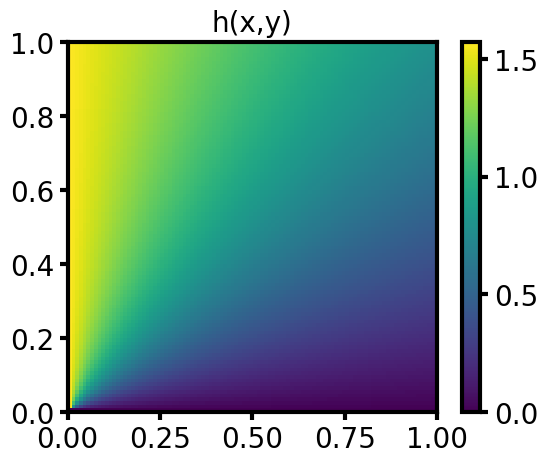

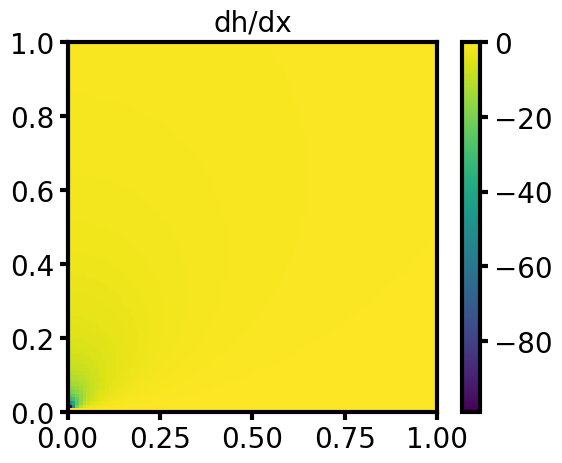

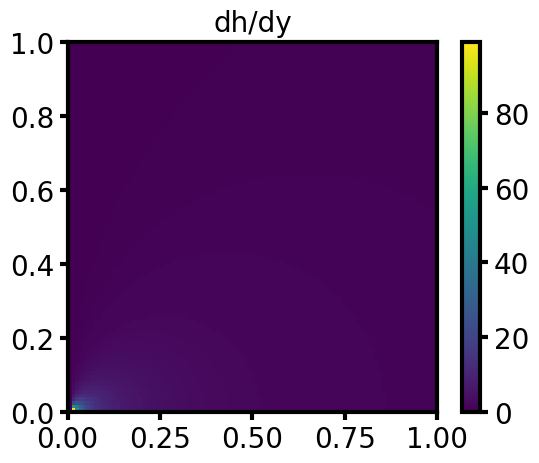

In [374]:
import matplotlib.pyplot as plt

X, Y = np.meshgrid(np.linspace(0,1,100), np.linspace(0,1,100))
H = np.zeros_like(X)
dHx = np.zeros_like(X)
dHy = np.zeros_like(X)

for i in range(100):
    for j in range(100):
        h_val, dhx, dhy = injection(X[i,j], Y[i,j])
        H[i,j] = h_val
        dHx[i,j] = dhx
        dHy[i,j] = dhy

plt.imshow(H, extent=[0,1,0,1], origin='lower')
plt.title('h(x,y)')
plt.colorbar()
plt.show()
plt.imshow(dHx, extent=[0,1,0,1], origin='lower')
plt.title('dh/dx')
plt.colorbar()
plt.show()
plt.imshow(dHy, extent=[0,1,0,1], origin='lower')
plt.title('dh/dy')
plt.colorbar()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


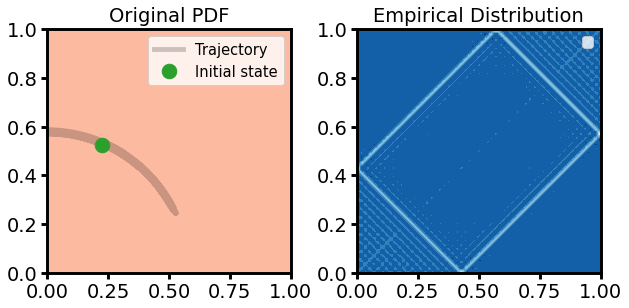

In [375]:
# reconstruct the emprical distribution
#phi_recon = np.zeros(grids.shape[0])
from scipy.spatial.distance import cdist
from numpy.linalg import solve
### Fourier
phi_recon = np.zeros(grids.shape[0])
for i, (k_vec, ck, hk) in enumerate(zip(ks, ck_list_update/(tsteps*dt), hk_list)):
    fk_vals = np.prod(np.cos(np.pi * k_vec / L_list * grids), axis=1)
    fk_vals /= hk
    phi_recon += ck * fk_vals

### Indicator
# Compute basis functions
"""fks = np.zeros((grids.shape[0], len(ks)))
for i,_ in enumerate(ks):
    f1 = sig(grids,lower[i])
    f2 = sig(grids,upper[i])
    fks[:, i] = np.prod(f1 * (1 - f2), axis=-1)

# Compute Gram matrix and RHS vector
    
G = fks.T @ (fks * dx * dy)
# Solve for coefficients
c = np.linalg.solve(G + 1e-6 * np.eye(G.shape[0]), ck_list_update/(tsteps*dt))
phi_recon = fks @ c"""

### Radial
"""pairwise_dists = cdist(centers, centers)
G = (sigma * np.sqrt(np.pi))**centers.shape[1] * np.exp(-pairwise_dists**2 / (4 * sigma**2))
a = solve(G, ck_list_update/(tsteps*dt))
grid_dists = cdist(grids, centers) 
rbf_vals = np.exp(-grid_dists**2 / (2 * sigma**2)) 
phi_recon = rbf_vals @ a"""

"""## Multiple Radials
M = centers.shape[0]
N = sigmas.shape[0]
d = centers.shape[1]
pairwise_centers = cdist(centers, centers, 'sqeuclidean')  # shape (M, M)
G = np.zeros((M, M))
for i in range(N):
    for m in range(N):
        coef = (np.sqrt(np.pi) * np.sqrt(2 * sigmas[i]**2 * sigmas[m]**2 / (sigmas[i]**2 + sigmas[m]**2)))**d
        exp_term = np.exp(-pairwise_centers / (2 * (sigmas[i]**2 + sigmas[m]**2)))
        G += weights[i] * weights[m] * coef * exp_term
rhs = np.zeros(M)
for i in range(N):
    coef = (np.sqrt(np.pi) * np.sqrt(2) * sigmas[i])**d
    rhs += weights[i] * coef * ck_list_update / (tsteps * dt)
c = np.linalg.solve(G + 1e-6 * np.eye(M), rhs)

sq_dists = cdist(grids, centers, 'sqeuclidean')
rbf_vals = np.zeros((grids.shape[0], M))
for i in range(N):
    rbf_vals += weights[i] * np.exp(-sq_dists / (2 * sigmas[i]**2))

phi_recon = rbf_vals @ c
"""
# visualize the trajectory
fig, axes = plt.subplots(1, 2, figsize=(9,5), dpi=70, tight_layout=True)
#fig, axes = plt.subplots(figsize=(6, 4), dpi=100, tight_layout=True) #### For now only one plot as i do not wish to reconstruct.
ax = axes[0]
ax.set_aspect('equal')
#ax.set_xlim(0.0, L_list[0])
#ax.set_ylim(0.0, L_list[1])
ax.set_title('Original PDF')
ax.contourf(grids_x, grids_y, pdf_vals.reshape(grids_x.shape), cmap='Reds')
ax.plot(x_traj[:,0], x_traj[:,1], linestyle='-', marker='', color='k', alpha=0.2, label='Trajectory')
ax.plot(x_traj[0,0], x_traj[0,1], linestyle='', marker='o', markersize=15, color='C2', alpha=1.0, label='Initial state')
ax.legend(loc=1)

ax = axes[1]
ax.set_aspect('equal')
ax.set_xlim(0.0, L_list[0])
ax.set_ylim(0.0, L_list[1])
ax.set_title('Empirical Distribution')
ax.contourf(grids_x, grids_y, phi_recon.reshape(grids_x.shape), cmap='Blues')
ax.legend(loc=1)
fig.tight_layout()
fig.subplots_adjust(top=0.9)  # adjust if title overlaps with subplots
#fig.suptitle(f"Radial basis with \sigma {sigmas[0][0]} on {num_k_per_dim}x{num_k_per_dim} Grid for {dt * tsteps} seconds", fontsize=16)
plt.show()
plt.close()



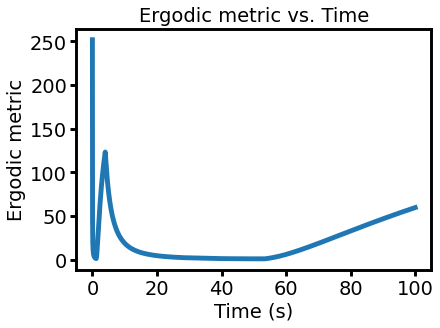

In [376]:
# Also visualize the ergodic metric over time
fig, ax = plt.subplots(1, 1, dpi=70, tight_layout=True)

ax.plot(np.arange(tsteps)*dt, metric_log)
ax.set_title('Ergodic metric vs. Time')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Ergodic metric')

plt.show()
plt.close()

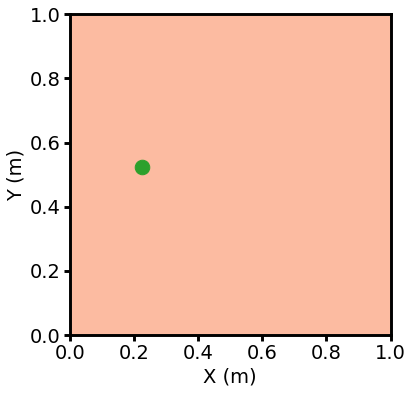

In [377]:
# Generate animation (takes about 1 minute)
from IPython.display import HTML
from matplotlib import animation

fig, ax = plt.subplots(1, 1, figsize=(6,7), dpi=70, tight_layout=True)
ax.set_aspect('equal')
ax.set_xlim(0.0, 1.0)
ax.set_ylim(0.0, 1.0)
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.contourf(grids_x, grids_y, pdf_vals.reshape(grids_x.shape), cmap='Reds', levels=10)

robot_traj, = ax.plot([], [], linestyle='-', marker='', color='k', alpha=0.2)
robot_state, = ax.plot(x_traj[0,0], x_traj[0,1], linestyle='', marker='o', markersize=15, color='C2')

def update_plot(frame):
    t = int(frame * 20)
    robot_state.set_data(
        np.array([x_traj[t][0]]), np.array([x_traj[t][1]])
    )
    robot_traj.set_data(
        x_traj[:t,0][::20], x_traj[:t,1][::20]
    )

    return robot_state, robot_traj,

#ani = animation.FuncAnimation(fig, update_plot, frames=int(tsteps/20)-1, blit=True, interval=30, repeat=False)
#video = ani.to_html5_video()
#HTML(video)